In [ ]:
# 1. 필수 도구 설치
!apt-get update && apt-get install -y wget unzip git

# GitHub CLI 설치
!type gh >/dev/null 2>&1 || (type -p curl >/dev/null || apt install curl -y && curl -fsSL https://cli.github.com/packages/githubcli-archive-keyring.gpg | gpg --dearmor -o /usr/share/keyrings/githubcli-archive-keyring.gpg && \
    echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/githubcli-archive-keyring.gpg] https://cli.github.com/packages stable main" | tee /etc/apt/sources.list.d/github-cli.list > /dev/null && \
    apt update && apt install gh -y)

# CodeQL CLI 다운로드 및 설치 (최신 버전)
!wget https://github.com/github/codeql-cli-binaries/releases/latest/download/codeql-linux64.zip
!unzip codeql-linux64.zip
!mv codeql /usr/local/codeql

# PATH 설정
import os
os.environ["PATH"] += ":/usr/local/codeql"

# 설치 확인
!codeql version

# 2. CodeQL 공식 쿼리 저장소 다운로드
!git clone https://github.com/github/codeql.git /usr/local/codeql-repo




Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Pack

In [ ]:
import pandas as pd
import json
from google.colab import drive

# Google Drive 마운트 (이미 마운트되어 있다면 생략 가능)
try:
    drive.mount('/content/drive')
except:
    print("Google Drive already mounted.")

# JSON 파일 경로 설정
file_path = '/content/drive/MyDrive/fortmp/' # 실제 파일 경로로 수정


Mounted at /content/drive


# 데이터셋 일부 dataframe으로 만듬

무슨 취약점인지 아는 데이터셋 중 command-injection 을 가져옴

In [ ]:
import os
import pandas as pd
import json

# JSON 파일들이 있는 폴더 경로 설정
folder_path = '/content/drive/MyDrive/fortmp/' # 실제 폴더 경로로 수정

# DataFrame으로 변환할 데이터 리스트 초기화
rows = []

# 폴더 내 모든 파일 목록 가져오기
try:
    file_list = os.listdir(folder_path)
except FileNotFoundError:
    print(f"오류: 폴더를 찾을 수 없습니다. 경로를 확인해주세요: {folder_path}")
    file_list = [] # Empty list to prevent further processing

# JSON 파일만 필터링하여 처리 (파일 이름이 'plain_'으로 시작하는 경우)
json_files = [f for f in file_list if f.startswith('plain_')]

if not json_files:
    print(f"경고: 지정된 폴더 '{folder_path}'에 'plain_'으로 시작하는 파일이 없습니다.")

for file_name in json_files:
    file_path = os.path.join(folder_path, file_name)
    print(f"Processing file: {file_path}") # Processing message for each file

    # JSON 파일 읽기
    try:
        with open(file_path, 'r', encoding='utf-8') as f: # Added encoding for robustness
            data = json.load(f)

        # JSON 데이터 순회하며 정보 추출 (repo -> commit -> file -> change 구조)
        # data가 딕셔너리인지 확인
        if isinstance(data, dict):
            for repo, commits in data.items():          # repo 단위
                # commits가 딕셔너리인지 확인
                if isinstance(commits, dict):
                    for sha, meta in commits.items():      # commit 단위
                        # meta가 딕셔너리이고 'files' 키가 있는지 확인
                        if isinstance(meta, dict) and 'files' in meta and isinstance(meta['files'], dict):
                            for filepath, filedata in meta["files"].items():   # 파일 단위
                                # filedata가 딕셔너리이고 'changes' 키가 있는지 확인
                                if isinstance(filedata, dict) and 'changes' in filedata and isinstance(filedata['changes'], list):
                                    for change in filedata["changes"]:            # change block 단위
                                        # change가 딕셔너리인지 확인
                                        if isinstance(change, dict):
                                            rows.append({
                                                "repo": repo,
                                                "sha": sha,
                                                "keyword": meta.get("keyword"),
                                                "url": meta.get("url"),
                                                "html_url": meta.get("html_url"),
                                                "diff": meta.get("diff"),
                                                "msg": meta.get("msg"),
                                                "file": filepath,
                                                "add": change.get("add"),
                                                "remove": change.get("remove"),
                                                "badparts": change.get("badparts"),
                                                "goodparts": change.get("goodparts"),
                                                "source": filedata.get("source"),
                                                "sourceWithComments": filedata.get("sourceWithComments")
                                            })
                                else:
                                    print(f"경고: 파일 '{file_name}'의 '{filepath}'에 대한 'changes' 데이터 형식이 올바르지 않습니다. 스킵합니다.")
                        else:
                            print(f"경고: 파일 '{file_name}'의 '{sha}' 커밋 메타데이터 형식이 올바르지 않거나 'files' 키가 없습니다. 스킵합니다.")
                else:
                     print(f"경고: 파일 '{file_name}'의 '{repo}' 저장소 커밋 데이터 형식이 올바르지 않습니다. 스킵합니다.")
        else:
            print(f"경고: 파일 '{file_name}'의 최상위 데이터 형식이 딕셔너리가 아닙니다. 스킵합니다.")


    except FileNotFoundError:
        print(f"오류: 파일 처리 중 파일을 찾을 수 없습니다: {file_path}") # Should not happen if listdir is correct, but for safety
    except json.JSONDecodeError:
        print(f"오류: 파일 '{file_name}'을 JSON 형식으로 읽는 데 실패했습니다. 파일 형식을 확인해주세요.")
    except Exception as e:
        print(f"파일 '{file_name}' 처리 중 예상치 못한 오류가 발생했습니다: {e}")

# 리스트를 DataFrame으로 변환
df = pd.DataFrame(rows)

# DataFrame 출력
if not df.empty:
    print("\nCombined DataFrame:")
    display(df.head())
    print(f"\nTotal rows in DataFrame: {len(df)}")
else:
    print("\nDataFrame is empty. No data was successfully processed.")

Processing file: /content/drive/MyDrive/fortmp/plain_remote_code_execution
Processing file: /content/drive/MyDrive/fortmp/plain_path_disclosure
Processing file: /content/drive/MyDrive/fortmp/plain_sql
Processing file: /content/drive/MyDrive/fortmp/plain_command_injection
Processing file: /content/drive/MyDrive/fortmp/plain_xss
Processing file: /content/drive/MyDrive/fortmp/plain_xsrf
Processing file: /content/drive/MyDrive/fortmp/plain_open_redirect

Combined DataFrame:


,repo,sha,keyword,url,html_url,diff,msg,file,add,remove,badparts,goodparts,source,sourceWithComments
0,https://github.com/Internet-of-People/titania-os,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,1,1,"[import common, sqlite3, subprocess, NetworkMa...","[import common, sqlite3, subprocess, NetworkMa...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
1,https://github.com/Internet-of-People/titania-os,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,2,1,"[ os.system(""useradd -G docker,wheel -p ""+e...","[ subprocess.call(['useradd','-G','docker,w...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
2,https://github.com/Internet-of-People/titania-ux,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,1,1,"[import common, sqlite3, subprocess, NetworkMa...","[import common, sqlite3, subprocess, NetworkMa...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
3,https://github.com/Internet-of-People/titania-ux,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,2,1,"[ os.system(""useradd -G docker,wheel -p ""+e...","[ subprocess.call(['useradd','-G','docker,w...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
4,https://github.com/DavidPL1/Hyperion,269b8c87afc149911af3ae63b3ccbfc77ffb223d,remote code execution check,https://api.github.com/repos/DavidPL1/Hyperion...,https://github.com/DavidPL1/Hyperion/commit/26...,diff --git a/hyperion/hyperion.py b/hyperion/h...,Utilize slave execution for remote checks\n\nO...,/hyperion/hyperion.py,7,1,"[ return check_component(comp, self.ses...","[ if self.run_on_localhost(comp):, ...",\n\nfrom libtmux import Server from yaml impor...,#! /usr/bin/env python\nfrom libtmux import Se...



Total rows in DataFrame: 4530


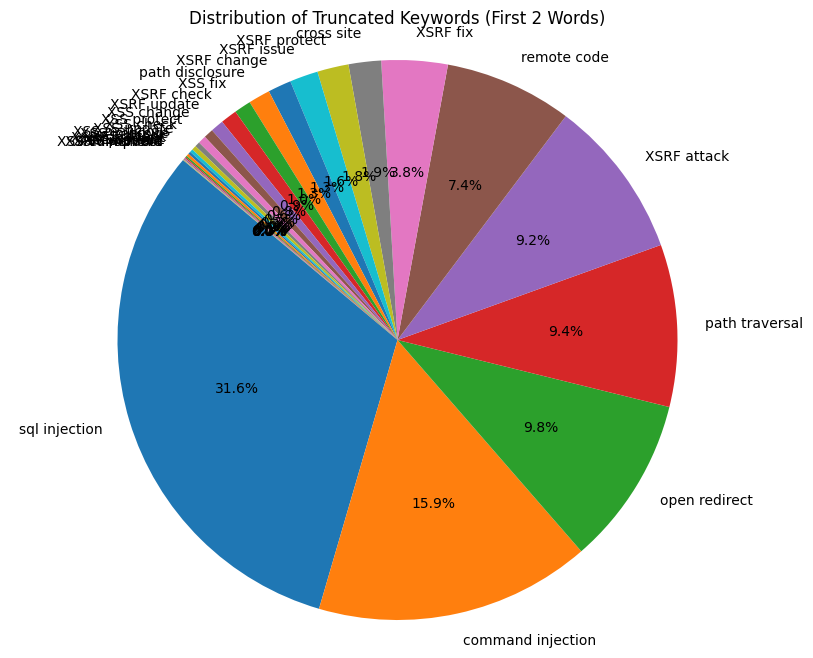

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 'keyword' 컬럼의 각 문자열에서 앞 두 단어만 추출
# 공백으로 분리하고 처음 두 요소(있는 경우)를 가져와 다시 결합
# 두 단어 미만인 경우는 있는 단어만 사용
df['keyword_truncated'] = df['keyword'].apply(lambda x: ' '.join(str(x).split()[:2]))

# 새로운 'keyword_truncated' 컬럼의 각 값의 개수를 계산
keyword_counts_truncated = df['keyword_truncated'].value_counts()

# 파이 차트 생성
plt.figure(figsize=(10, 8))
plt.pie(keyword_counts_truncated, labels=keyword_counts_truncated.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Truncated Keywords (First 2 Words)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 분석 후 임시 컬럼 삭제 (선택 사항)
# df = df.drop(columns=['keyword_truncated'])

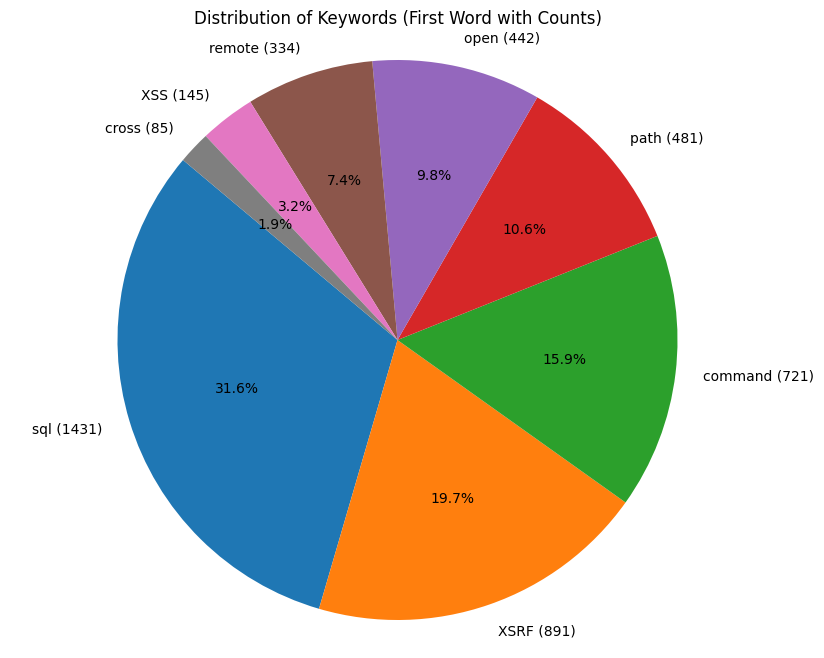

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 'keyword' 컬럼의 각 문자열에서 맨 앞 1단어만 추출
df['keyword_first_word'] = df['keyword'].apply(lambda x: str(x).split()[0] if str(x).split() else '')

# 새로운 'keyword_first_word' 컬럼의 각 값의 개수를 계산
keyword_counts_first_word = df['keyword_first_word'].value_counts()

# 파이 차트 생성
plt.figure(figsize=(10, 8))

# 라벨에 개수 추가
labels_with_counts = [f'{label} ({count})' for label, count in keyword_counts_first_word.items()]

plt.pie(keyword_counts_first_word, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Keywords (First Word with Counts)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 분석 후 임시 컬럼 삭제 (선택 사항)
# df = df.drop(columns=['keyword_first_word'])

In [ ]:
# DataFrame을 CSV 파일로 저장
# 저장할 파일 경로 지정
csv_file_path = '/content/drive/MyDrive/fortmp/plain_vulset.csv'

# DataFrame을 CSV 파일로 저장 (인덱스는 제외)
#df.to_csv(csv_file_path, index=False)

print(f"DataFrame이 '{csv_file_path}'에 성공적으로 저장되었습니다.")
df = pd.read_csv(csv_file_path)
df

DataFrame이 '/content/drive/MyDrive/fortmp/plain_vulset.csv'에 성공적으로 저장되었습니다.


,repo,sha,keyword,url,html_url,diff,msg,file,add,remove,badparts,goodparts,source,sourceWithComments
0,https://github.com/Internet-of-People/titania-os,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,1,1,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
1,https://github.com/Internet-of-People/titania-os,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,2,1,"[' os.system(""useradd -G docker,wheel -p ""+...","["" subprocess.call(['useradd','-G','docker,...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
2,https://github.com/Internet-of-People/titania-ux,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,1,1,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
3,https://github.com/Internet-of-People/titania-ux,9b7805119938343fcac9dc929d8882f1d97cf14a,remote code execution change,https://api.github.com/repos/Internet-of-Peopl...,https://github.com/Internet-of-People/titania-...,diff --git a/vuedj/configtitania/views.py b/vu...,#21 Unauthenticated remote root code execution...,/vuedj/configtitania/views.py,2,1,"[' os.system(""useradd -G docker,wheel -p ""+...","["" subprocess.call(['useradd','-G','docker,...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
4,https://github.com/DavidPL1/Hyperion,269b8c87afc149911af3ae63b3ccbfc77ffb223d,remote code execution check,https://api.github.com/repos/DavidPL1/Hyperion...,https://github.com/DavidPL1/Hyperion/commit/26...,diff --git a/hyperion/hyperion.py b/hyperion/h...,Utilize slave execution for remote checks\n\nO...,/hyperion/hyperion.py,7,1,"[' return check_component(comp, self.se...","[' if self.run_on_localhost(comp):', ' ...",\n\nfrom libtmux import Server from yaml impor...,#! /usr/bin/env python\nfrom libtmux import Se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4525,https://github.com/hyperion-start/hyperion-core,671a06608c5210f205d93c0c235c94a8783892b9,open redirect change,https://api.github.com/repos/hyperion-start/hy...,https://github.com/hyperion-start/hyperion-cor...,diff --git a/hyperion/lib/monitoring/threads.p...,Patch host connection status detection\n\nos.s...,/hyperion/manager.py,2,1,"[' sys.exit(""Host \'%s\' is unknown...","[' self.logger.error(""Host \'%s\' i...",NaN,NaN
4526,https://github.com/widelands/widelands-website,0c72e43a4863d07468a090cd4365c5505deb715b,open redirect check,https://api.github.com/repos/widelands/widelan...,https://github.com/widelands/widelands-website...,diff --git a/wiki/forms.py b/wiki/forms.py\nin...,trying to edit a redirect opens now the actual...,/wiki/forms.py,22,10,"[' 1. Check for bad characters', ' ...","[' 1. Check for bad characters', ' ...",\n\nimport re from django import forms from dj...,# -*- coding: utf-8 -*-\nimport re\n\nfrom dja...
4527,https://github.com/widelands/widelands-website,0c72e43a4863d07468a090cd4365c5505deb715b,open redirect check,https://api.github.com/r

In [ ]:

row_index =

if row_index < len(df):
    selected_row = df.iloc[row_index]

    # goodparts 컬럼 출력
    print("Good Parts:")
    print(selected_row['goodparts'])

    # badparts 컬럼 출력
    print("\nBad Parts:")
    print(selected_row['badparts'])
else:
    print(f"Error: Row index {row_index} is out of bounds for the DataFrame.")

Good Parts:
['        if len(pids) < 2:']

Bad Parts:
['        if len(pids) < 3:']


In [ ]:
import ast
import numpy as np

def count_list_elements(list_string):
    """Safely evaluates a string representation of a list and returns the number of elements."""
    if pd.isna(list_string):
        return 0
    try:
        # Safely evaluate the string as a Python literal (list, tuple, string, number, dict, boolean, None)
        evaluated_list = ast.literal_eval(list_string)
        if isinstance(evaluated_list, (list, tuple)):
            # Count elements if it's a list or tuple
            return len(evaluated_list)
        else:
            # If it's not a list or tuple, treat it as a single element or 0 if empty/None
            return 1 if evaluated_list is not None and evaluated_list != '' else 0
    except (ValueError, SyntaxError):
        # Handle cases where the string is not a valid list representation
        return 0

# Apply the function to count elements in 'goodparts' and 'badparts'
df['goodparts_count'] = df['goodparts'].apply(count_list_elements)
df['badparts_count'] = df['badparts'].apply(count_list_elements)

# Calculate the average count for each column
average_goodparts_count = df['goodparts_count'].mean()
average_badparts_count = df['badparts_count'].mean()

print(f"Average number of elements in 'goodparts': {average_goodparts_count:.2f}")
print(f"Average number of elements in 'badparts': {average_badparts_count:.2f}")

# Display the new columns and the first few rows (optional)
# display(df[['goodparts', 'badparts', 'goodparts_count', 'badparts_count']].head())

Average number of elements in 'goodparts': 4.88
Average number of elements in 'badparts': 3.80


In [ ]:
df.isna().sum()

,0
repo,0
sha,0
keyword,0
url,0
html_url,0
diff,0
msg,0
file,0
add,0
remove,0


In [ ]:
# 'source' 컬럼에 NaN 값이 있는 행 필터링 (이전 단계에서 수행됨)
nan_source_rows = df[df['source'].isna()]

# 필터링된 행들의 'keyword' 컬럼 값 개수 계산
if not nan_source_rows.empty:
    nan_keywords = nan_source_rows['keyword'].value_counts()

    print("\nKeywords associated with rows having NaN in 'source':")
    display(nan_keywords)
else:
    print("\nNo keywords found for rows with NaN in 'source' (DataFrame is empty).")


Keywords associated with rows having NaN in 'source':


,count
keyword,
command injection attack,295
XSRF attack,78
open redirect fix,54
open redirect prevent,34
XSRF fix,32
sql injection fix,21
remote code execution prevent,16
sql injection prevent,12
remote code execution protect,10


In [ ]:
# 'keyword' 컬럼의 고유한 값들을 가져옴
unique_keywords = df['keyword'].unique()

# 고유한 값들을 문자열로 변환하여 출력
print("Unique keywords in the DataFrame:")
print(", ".join(unique_keywords))

Unique keywords in the DataFrame:
remote code execution change, remote code execution check, remote code execution improve, remote code execution prevent, remote code execution fix, remote code execution issue, remote code execution protect, remote code execution correct, remote code execution malicious, path disclosure fix, path disclosure issue, path traversal change, path traversal issue, path traversal improve, path traversal fix, path disclosure update, path traversal correct, path disclosure prevent, path disclosure improve, path disclosure check, path traversal prevent, path traversal attack, path traversal update, path traversal check, sql injection prevent, sql injection attack, sql injection protect, sql injection correct, sql injection check, sql injection fix, sql injection change, sql injection vulnerable, sql injection improve, sql injection issue, sql injection update, sql injection malicious, sql injection insecure, sql injection vulnerability, command injection update,

In [ ]:
# DataFrame의 첫 번째 행 선택
first_row = df.iloc[4]

# source 컬럼 출력
print("Source:")
print(first_row['source'])

# sourceWithComments 컬럼 출력
print("\n====================\ngood parts:")
print(first_row['goodparts'])
print("\n====================\nbad parts:")
print(first_row['badparts'])

Source:


from libtmux import Server from yaml import load, dump from setupParser import Loader from DepTree import Node, dep_resolve, CircularReferenceException import logging import os import socket import argparse from psutil import Process from subprocess import call from graphviz import Digraph from enum import Enum from time import sleep import sys from PyQt4 import QtGui import hyperGUI FORMAT="%(asctime)s: %(name)s[%(levelname)s]:\t%(message)s" logging.basicConfig(level=logging.WARNING, format=FORMAT, datefmt='%I:%M:%S') TMP_SLAVE_DIR="/tmp/Hyperion/slave/components" TMP_COMP_DIR="/tmp/Hyperion/components" TMP_LOG_PATH="/tmp/Hyperion/log" BASE_DIR=os.path.dirname(__file__) SCRIPT_CLONE_PATH=("%s/scripts/start_named_clone_session.sh" % BASE_DIR) class CheckState(Enum): RUNNING=0 STOPPED=1 STOPPED_BUT_SUCCESSFUL=2 STARTED_BY_HAND=3 DEP_FAILED=4 class ControlCenter: def __init__(self, configfile=None): self.logger=logging.getLogger(__name__) self.logger.setLevel(logging.DEBUG) sel

In [ ]:
import os

# folder_path는 이전 셀에서 이미 정의되었습니다.
file_path = '/content/drive/MyDrive/fortmp/'

# 읽을 파일 이름 지정
file_name_to_read = 'xss_dataset_finaltest_X'

# 전체 파일 경로 생성
full_file_path = os.path.join(file_path, file_name_to_read)

# 파일 내용의 일부 읽기 (예: 첫 10줄)
try:
    with open(full_file_path, 'r', encoding='latin-1') as f: #
        print(f"파일 '{file_name_to_read}'의 내용을 일부 읽습니다 (첫 10줄):")
        for i in range(10):
            line = f.readline()
            if not line:
                break # 파일의 끝에 도달하면 중지
            print(line.strip()) # 줄바꿈 문자 제거하고 출력

except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요: {full_file_path}")
except Exception as e:
    print(f"파일을 읽는 중 오류가 발생했습니다: {e}")

파일 'xss_dataset_finaltest_X'의 내용을 일부 읽습니다 (첫 10줄):
]q (]q(]q(G?°º    GÀR-À   GÀ
(Þ@   G?ë§À   GÀ}z   G?çuëÀ   G¿ºü'@   GÀ	Dq    GÀsø`   G@?    G@lÀ   G@V[à   GÀlÓ@   G?ÄÑ¯    G¿òV    G@	ÛË    G¿Èn    G¿ûÕ`   GÀõøà   G?ÓÒ¬    G¿÷ä    G¿çè`   G?ÏKô   G@Å    G¿ë¾    G?ø@   G@ÞU    G?Ð&À   GÀ ìc@   G?ôâa    G¿ìÇ    G@rÑ    G?ê@   G?øºø    G¿òzR@   G?þPÀ   G@Þ    G?È!½@   G?¶À   G?å@   G¿ë» à   GÀ-Î@   G?ëà   G¿ð!¹à   G?ü¯à   G¿þV&    G?ÿHÃ   G?­vÀ   G?ÚÜÀ   G?êÌ@   G¿ûâ@   G?ñ »    GÀ.KÀ   G¿áº(    G@HW    G?ò<`   G?ùç×`   G?Û`   G?¿ù   G?ññ    GÀ&A    G?M    G¿â=Þ`   G@ï=à   G¿Ñ¾g    G¿ígË`   G¿ú¨é    GÀ ²¿    GÀ¸.    GÀa}`   GÀQY    G@;À   G@ðõ`   G@
à   G?è2`   GÀ´   G¿çbÛà   GÀwà   G¿ä­    G?ê>Ç   G@Û    G?æè¾À   G¿úé    G¿ñúÐ   GÀ
ÁÄ   G?úö@   G?ü àÀ   G?µVd    G?Ü5À   GÀgî    G¿Ö.9@   G?âí@   G?÷pÀ   G¿áôñ`   G¿×>e@   G?¹Õóà   G?ño    G@±Ö    G?ÿïáÀ   GÀ=@   G?üµï`   G@9³`   G¿ìÀz    G¿åb;   

# 데이터 정제

In [ ]:
# 'keyword' 컬럼의 각 문자열에서 앞 두 단어만 추출
# 공백으로 분리하고 처음 두 요소(있는 경우)를 가져와 다시 결합
# 두 단어 미만인 경우는 있는 단어만 사용
df['keyword_truncated'] = df['keyword'].apply(lambda x: ' '.join(str(x).split()[:2]))

# 새로운 'keyword_truncated' 컬럼의 각 값의 개수를 계산
keyword_counts_truncated = df['keyword_truncated'].value_counts()

print("Distribution of truncated keywords (first 2 words):")
display(keyword_counts_truncated)

# 분석 후 임시 컬럼 삭제 (선택 사항)
# df = df.drop(columns=['keyword_truncated'])

Distribution of truncated keywords (first 2 words):


,count
keyword_truncated,
sql injection,1431
command injection,721
open redirect,442
path traversal,424
XSRF attack,418
remote code,334
XSRF fix,173
cross site,85
XSRF protect,82


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 'keyword' 컬럼의 각 문자열에서 맨 앞 1단어만 추출
df['keyword_first_word'] = df['keyword'].apply(lambda x: str(x).split()[0] if str(x).split() else '')

# 새로운 'keyword_first_word' 컬럼의 각 값의 개수를 계산
keyword_counts_first_word = df['keyword_first_word'].value_counts()

# 결과 출력
print("Distribution of keywords (first word):")
display(keyword_counts_first_word)

# 분석 후 임시 컬럼 삭제 (선택 사항)
#df_alt = df.drop(columns=['keyword_first_word'])

Distribution of keywords (first word):


,count
keyword_first_word,
sql,1431
XSRF,891
command,721
path,481
open,442
remote,334
XSS,145
cross,85


In [ ]:
# 필요한 컬럼만 선택하여 새로운 DataFrame 생성 및 컬럼 순서 변경
df_new = df[['sha', 'keyword_first_word', 'goodparts', 'badparts', 'source', 'sourceWithComments']].copy()

# 'keyword_first_word' 컬럼의 이름을 'keyword'로 변경
df_new.rename(columns={'keyword_first_word': 'keyword'}, inplace=True)

# 새로운 DataFrame df_new의 정보와 처음 몇 행 출력
print("Info of the new DataFrame df_new:")
df_new.info()

print("\nFirst few rows of the new DataFrame df_new:")
df_new

Info of the new DataFrame df_new:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4530 entries, 0 to 4529
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sha                 4530 non-null   object
 1   keyword             4530 non-null   object
 2   goodparts           4530 non-null   object
 3   badparts            4530 non-null   object
 4   source              3896 non-null   object
 5   sourceWithComments  3896 non-null   object
dtypes: object(6)
memory usage: 212.5+ KB

First few rows of the new DataFrame df_new:


,sha,keyword,goodparts,badparts,source,sourceWithComments
0,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
1,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,"["" subprocess.call(['useradd','-G','docker,...","[' os.system(""useradd -G docker,wheel -p ""+...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
2,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
3,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,"["" subprocess.call(['useradd','-G','docker,...","[' os.system(""useradd -G docker,wheel -p ""+...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
4,269b8c87afc149911af3ae63b3ccbfc77ffb223d,remote,"[' if self.run_on_localhost(comp):', ' ...","[' return check_component(comp, self.se...",\n\nfrom libtmux import Server from yaml impor...,#! /usr/bin/env python\nfrom libtmux import Se...
...,...,...,...,...,...,...
4525,671a06608c5210f205d93c0c235c94a8783892b9,open,"[' self.logger.error(""Host \'%s\' i...","[' sys.exit(""Host \'%s\' is unknown...",NaN,NaN
4526,0c72e43a4863d07468a090cd4365c5505deb715b,open,"[' 1. Check for bad characters', ' ...","[' 1. Check for bad characters', ' ...",\n\nimport re from django import forms from dj...,# -*- coding: utf-8 -*-\nimport re\n\nfrom dja...
4527,0c72e43a4863d07468a090cd4365c5505deb715b,open,[],['from django.core.exceptions import ObjectDoe...,\n from datetime import datetime from django.c...,# -*- coding: utf-8 -*-\n\nfrom datetime impor...
4528,0c72e43a4863d07468a090cd4365c5505deb715b,open,"[' try:', ' cs = ChangeSet.o...",[' article = None'],\n from datetime import datetime from django.c...,# -*- coding: utf-8 -*-\n\nfrom datetime impor...


In [ ]:
# CWE 매핑 딕셔너리
cwe_mapping = {
    'sql': 'CWE-89',
    'remote': 'CWE-94',
    'path': 'CWE-538',
    'XSS': 'CWE-79',
    'XSRF': 'CWE-352',
    'open': 'CWE-601',
    'cross' : 'CWE-79',
    'command':'CWE-77'
}

# 'CWE' 컬럼 추가 및 매핑 적용
# 'keyword' 컬럼의 값에 따라 CWE 값을 할당하고, 매핑에 없는 경우는 None 또는 다른 값으로 처리
df_new['CWE'] = df_new['keyword'].map(cwe_mapping)

# 'CWE' 컬럼을 3번째 열 (인덱스 2)에 삽입
# 현재 컬럼 순서를 가져와서 'CWE'를 삽입할 위치를 찾습니다.
current_columns = df_new.columns.tolist()
# 'CWE'가 이미 있으면 제거하고 다시 삽입합니다.
if 'CWE' in current_columns:
    current_columns.remove('CWE')

# 'CWE'를 원하는 위치에 삽입합니다.
current_columns.insert(2, 'CWE')

# 새로운 컬럼 순서로 df_new를 재정렬합니다.
df_new = df_new[current_columns]

# 결과 확인
print("Info of the updated DataFrame df_new:")
df_new.info()

print("\nFirst few rows of the updated DataFrame df_new with CWE column:")
df_new

Info of the updated DataFrame df_new:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4530 entries, 0 to 4529
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sha                 4530 non-null   object
 1   keyword             4530 non-null   object
 2   CWE                 4530 non-null   object
 3   goodparts           4530 non-null   object
 4   badparts            4530 non-null   object
 5   source              3896 non-null   object
 6   sourceWithComments  3896 non-null   object
dtypes: object(7)
memory usage: 247.9+ KB

First few rows of the updated DataFrame df_new with CWE column:


,sha,keyword,CWE,goodparts,badparts,source,sourceWithComments
0,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
1,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"["" subprocess.call(['useradd','-G','docker,...","[' os.system(""useradd -G docker,wheel -p ""+...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
2,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
3,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"["" subprocess.call(['useradd','-G','docker,...","[' os.system(""useradd -G docker,wheel -p ""+...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
4,269b8c87afc149911af3ae63b3ccbfc77ffb223d,remote,CWE-94,"[' if self.run_on_localhost(comp):', ' ...","[' return check_component(comp, self.se...",\n\nfrom libtmux import Server from yaml impor...,#! /usr/bin/env python\nfrom libtmux import Se...
...,...,...,...,...,...,...,...
4525,671a06608c5210f205d93c0c235c94a8783892b9,open,CWE-601,"[' self.logger.error(""Host \'%s\' i...","[' sys.exit(""Host \'%s\' is unknown...",NaN,NaN
4526,0c72e43a4863d07468a090cd4365c5505deb715b,open,CWE-601,"[' 1. Check for bad characters', ' ...","[' 1. Check for bad characters', ' ...",\n\nimport re from django import forms from dj...,# -*- coding: utf-8 -*-\nimport re\n\nfrom dja...
4527,0c72e43a4863d07468a090cd4365c5505deb715b,open,CWE-601,[],['from django.core.exceptions import ObjectDoe...,\n from datetime import datetime from django.c...,# -*- coding: utf-8 -*-\n\nfrom datetime impor...
4528,0c72e43a4863d07468a090cd4365c5505deb715b,open,CWE-601,"[' try:', ' cs = ChangeSet.o...",[' article = None'],\n from datetime import datetime from django.c...,# -*- coding: utf-8 -*-\n\nfrom datetime impor...


In [ ]:
# 'keyword'와 'CWE' 컬럼을 기준으로 그룹화하고 각 그룹의 크기(개수)를 계산
keyword_cwe_counts = df_new.groupby(['keyword', 'CWE']).size().reset_index(name='count')

print("Count of values per keyword and CWE combination:")
display(keyword_cwe_counts)
print(keyword_cwe_counts.sum())

Count of values per keyword and CWE combination:


,keyword,CWE,count
0,XSRF,CWE-352,891
1,XSS,CWE-79,145
2,command,CWE-77,721
3,cross,CWE-79,85
4,open,CWE-601,442
5,path,CWE-538,481
6,remote,CWE-94,334
7,sql,CWE-89,1431


keyword                 XSRFXSScommandcrossopenpathremotesql
CWE        CWE-352CWE-79CWE-77CWE-79CWE-601CWE-538CWE-94C...
count                                                   4530
dtype: object


In [ ]:
# 'source' 및 'sourceWithComments' 컬럼의 결측치 개수를 CWE별로 그룹화하여 계산
missing_counts_by_cwe = df_new.groupby('CWE')[['source', 'sourceWithComments']].apply(lambda x: x.isnull().sum())

print("Missing values in 'source' and 'sourceWithComments' columns by CWE label:")
display(missing_counts_by_cwe)

# 'source' 및 'sourceWithComments' 컬럼의 결측치를 제외한 개수를 CWE별로 그룹화하여 계산
non_missing_counts_by_cwe = df_new.groupby('CWE')[['source', 'sourceWithComments']].apply(lambda x: x.notnull().sum())

print("\nNon-missing values in 'source' and 'sourceWithComments' columns by CWE label:")
display(non_missing_counts_by_cwe)

Missing values in 'source' and 'sourceWithComments' columns by CWE label:


,source,sourceWithComments
CWE,,
CWE-352,129,129
CWE-538,6,6
CWE-601,96,96
CWE-77,321,321
CWE-79,7,7
CWE-89,37,37
CWE-94,38,38



Non-missing values in 'source' and 'sourceWithComments' columns by CWE label:


,source,sourceWithComments
CWE,,
CWE-352,762,762
CWE-538,475,475
CWE-601,346,346
CWE-77,400,400
CWE-79,223,223
CWE-89,1394,1394
CWE-94,296,296


In [ ]:
csv_file_path = '/content/drive/MyDrive/fortmp/CWE_vulset.csv'

# DataFrame을 CSV 파일로 저장 (인덱스는 제외)
#df_new.to_csv(csv_file_path, index=False)

In [ ]:
# df_new DataFrame에서 모든 NaN 값이 있는 행을 제거
print("Shape of df_new before dropping NaN:", df_new.shape)
df_new.dropna(inplace=True)
print("Shape of df_new after dropping NaN:", df_new.shape)

# 결과 확인 (처음 몇 행과 정보 출력)
print("\nInfo of df_new after dropping NaN:")
df_new.info()

print("\nFirst few rows of df_new after dropping NaN:")
display(df_new.head())

Shape of df_new before dropping NaN: (4530, 7)
Shape of df_new after dropping NaN: (3896, 7)

Info of df_new after dropping NaN:
<class 'pandas.core.frame.DataFrame'>
Index: 3896 entries, 0 to 4529
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sha                 3896 non-null   object
 1   keyword             3896 non-null   object
 2   CWE                 3896 non-null   object
 3   goodparts           3896 non-null   object
 4   badparts            3896 non-null   object
 5   source              3896 non-null   object
 6   sourceWithComments  3896 non-null   object
dtypes: object(7)
memory usage: 243.5+ KB

First few rows of df_new after dropping NaN:


/tmp/ipython-input-172872967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.dropna(inplace=True)


,sha,keyword,CWE,goodparts,badparts,source,sourceWithComments
0,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
1,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"["" subprocess.call(['useradd','-G','docker,...","[' os.system(""useradd -G docker,wheel -p ""+...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
2,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"['import common, sqlite3, subprocess, NetworkM...","['import common, sqlite3, subprocess, NetworkM...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
3,9b7805119938343fcac9dc929d8882f1d97cf14a,remote,CWE-94,"["" subprocess.call(['useradd','-G','docker,...","[' os.system(""useradd -G docker,wheel -p ""+...",\nfrom django.shortcuts import render from dja...,from django.shortcuts import render\nfrom djan...
4,269b8c87afc149911af3ae63b3ccbfc77ffb223d,remote,CWE-94,"[' if self.run_on_localhost(comp):', ' ...","[' return check_component(comp, self.se...",\n\nfrom libtmux import Server from yaml impor...,#! /usr/bin/env python\nfrom libtmux import Se...


In [ ]:
csv_file_path = '/content/drive/MyDrive/fortmp/CWE_vulset_noNaN.csv'

# DataFrame을 CSV 파일로 저장 (인덱스는 제외)
df_new.to_csv(csv_file_path, index=False)

# AST 만들기?

In [ ]:
!pip install redbaron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
# 일반 redbaron AST
from redbaron import RedBaron

code = df.loc[0, "sourceWithComments"]
red = RedBaron(code)
print(red)

0   <CommentNode path=[0], "#!/usr/bin/env p...n" 133432864626192, on RedBaron 133432827596336>
1   <CommentNode path=[2], "# -*- coding: ut...-" 133432803207088, on RedBaron 133432827596336>
2   '\n'
3   <FromImportNode path=[5], "from saker.fuzze...r" 133432803211360, on RedBaron 133432827596336>
4   '\n'
5   '\n'
6   <ClassNode path=[9], "class CmdInjecti...n" 133432803210976, on RedBaron 133432827596336>



In [ ]:
# pythin 모듈 AST 형식으로 바꾸기
import ast
from redbaron import RedBaron

code = df.loc[0, "sourceWithComments"]
red = RedBaron(code)

def red_to_ast(node):
    """RedBaron 노드를 Python AST 노드로 안전하게 변환"""
    if node is None:
        return None

    try:
        if node.type == 'class':
            # 상속 처리
            bases = []
            if hasattr(node, 'inherit_from') and node.inherit_from:
                for base in node.inherit_from:
                    if base is not None:
                        bases.append(ast.Name(id=base.value, ctx=ast.Load()))
            # body 변환
            body = []
            if hasattr(node, 'value'):
                for n in node.value:
                    child = red_to_ast(n)
                    if child:
                        body.append(child)
            if not body:
                body = [ast.Pass()]
            return ast.ClassDef(
                name=node.name,
                bases=bases,
                keywords=[],
                body=body,
                decorator_list=[]
            )

        elif node.type == 'def':
            # 함수 인자 처리
            args = []
            if hasattr(node, 'arguments') and node.arguments:
                for a in node.arguments:
                    if hasattr(a, 'name'):
                        args.append(ast.arg(arg=a.name))
            # body 변환
            body = []
            if hasattr(node, 'value'):
                for n in node.value:
                    child = red_to_ast(n)
                    if child:
                        body.append(child)
            if not body:
                body = [ast.Pass()]
            return ast.FunctionDef(
                name=node.name,
                args=ast.arguments(
                    posonlyargs=[],
                    args=args,
                    kwonlyargs=[],
                    kw_defaults=[],
                    defaults=[]
                ),
                body=body,
                decorator_list=[],
                returns=None
            )

        elif node.type == 'return':
            return ast.Return(value=red_to_ast(node.value))

        elif node.type == 'call':
            func = red_to_ast(node.value)
            args = [red_to_ast(a) for a in getattr(node, 'arguments', [])]
            args = [a for a in args if a is not None]
            return ast.Call(func=func, args=args, keywords=[])

        elif node.type == 'name':
            return ast.Name(id=node.value, ctx=ast.Load())

        elif node.type == 'atomtrailers':  # 속성, 메소드 호출 등
            if len(node) == 1 and node[0].type == 'name':
                return ast.Name(id=node[0].value, ctx=ast.Load())
            elif len(node) >= 3 and node[1].type == 'dot':
                return ast.Attribute(
                    value=ast.Name(id=node[0].value, ctx=ast.Load()),
                    attr=node[2].value,
                    ctx=ast.Load()
                )

        elif node.type == 'string':
            return ast.Constant(value=node.value.strip('"').strip("'"))

        elif node.type == 'expr':
            return red_to_ast(node.value)

        elif node.type == 'pass':
            return ast.Pass()

        elif node.type == 'assign':
            targets = [red_to_ast(t) for t in getattr(node, 'targets', []) if t is not None]
            value = red_to_ast(getattr(node, 'value', None))
            return ast.Assign(targets=targets, value=value)

        elif node.type == 'list':
            elts = [red_to_ast(e) for e in getattr(node, 'value', []) if e is not None]
            return ast.List(elts=elts, ctx=ast.Load())

    except Exception as e:
        # 변환 불가능한 노드는 None 반환
        return None

    return None


# 안전하게 변환
ast_nodes = []
for n in red:
    converted = red_to_ast(n)
    if converted:
        ast_nodes.append(converted)

module = ast.Module(body=ast_nodes, type_ignores=[])

print(ast.dump(module, indent=2))


Module(
  body=[
    ClassDef(
      name='CmdInjection',
      bases=[
        Name(id='Fuzzer', ctx=Load())],
      keywords=[],
      body=[
        Constant(value='CmdInjection'),
        FunctionDef(
          name='__init__',
          args=arguments(
            posonlyargs=[],
            args=[
              arg(arg=<NameNode path=[9, 'value', 5, 'arguments', 0, 'target'], "self" 133432810017984, on DefArgumentNode 133432810020768>)],
            kwonlyargs=[],
            kw_defaults=[],
            defaults=[]),
          body=[
            Pass()],
          decorator_list=[]),
        FunctionDef(
          name='test',
          args=arguments(
            posonlyargs=[],
            args=[
              arg(arg=<NameNode path=[9, 'value', 6, 'arguments', 0, 'target'], "self" 133432810014000, on DefArgumentNode 133432810012944>)],
            kwonlyargs=[],
            kw_defaults=[],
            defaults=[]),
          body=[
            Return(
              value=List(

In [ ]:
# redbaron을 그래프로 만들기 <- 아직 시도중
import networkx as nx

def ast_to_graph(node):
    G = nx.DiGraph()
    def visit(n, parent_id=None):
        node_id = id(n)
        G.add_node(node_id, type=type(n).__name__)
        if parent_id:
            G.add_edge(parent_id, node_id)
        for child in getattr(n, 'value', []):
            visit(child, node_id)
    visit(node)
    return G

graph = ast_to_graph(red)

# 노드 출력
print("Nodes:")
for node_id, data in graph.nodes(data=True):
    print(node_id, data)

# 엣지 출력
print("\nEdges:")
for edge in graph.edges():
    print(edge)


Nodes:
133432821322656 {'type': 'RedBaron'}

Edges:


In [ ]:
# 걍 파이썬 내장 모듈 써도 되긴 하나,
# python2는 지원을 안해서 애매함....
import ast

code = df.loc[0, "sourceWithComments"]
tree = ast.parse(code)
print(ast.dump(tree, indent=2))


Module(
  body=[
    ImportFrom(
      module='saker.fuzzers.fuzzer',
      names=[
        alias(name='Fuzzer')],
      level=0),
    ClassDef(
      name='CmdInjection',
      bases=[
        Name(id='Fuzzer', ctx=Load())],
      keywords=[],
      body=[
        Expr(
          value=Constant(value='CmdInjection')),
        FunctionDef(
          name='__init__',
          args=arguments(
            posonlyargs=[],
            args=[
              arg(arg='self')],
            kwonlyargs=[],
            kw_defaults=[],
            defaults=[]),
          body=[
            Expr(
              value=Call(
                func=Attribute(
                  value=Call(
                    func=Name(id='super', ctx=Load()),
                    args=[
                      Name(id='CmdInjection', ctx=Load()),
                      Name(id='self', ctx=Load())],
                    keywords=[]),
                  attr='__init__',
                  ctx=Load()),
                args=[],
    

# LSTM

대충 이렇 flow로 간다지 \
데이터 이따구로 적게 집어넣을 생각은 없음

In [ ]:
!pip install gensim

In [ ]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# ================================
# 1. 예시 데이터 (원래는 소스코드 토큰이 들어감)
# ================================
corpus = [
    ["int", "main", "(", ")", "{", "strcpy", "(", "buf", ",", "input", ")", ";", "}"],  # vulnerable
    ["int", "main", "(", ")", "{", "fgets", "(", "buf", ",", "100", ",", "stdin", ")", ";", "}"],  # safe
    ["if", "(", "x", ">", "y", ")", "{", "return", "x", ";", "}"],  # safe
    ["gets", "(", "input", ")", ";"]  # vulnerable
]

labels = [1, 0, 0, 1]  # 1 = vulnerable, 0 = safe

# ================================
# 2. Word2Vec 임베딩 학습
# ================================
w2v_model = Word2Vec(sentences=corpus, vector_size=50, window=5, min_count=1, workers=4)
embedding_dim = 50

# gensim Word2Vec의 vocab 가져오기
word_index = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}

# ================================
# 3. 텍스트를 정수 인덱스로 변환
# ================================
tokenizer = Tokenizer(num_words=len(word_index) + 1)
tokenizer.word_index = word_index
sequences = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(sequences, padding="post", maxlen=20)

y = np.array(labels)


In [ ]:
# ================================
# 4. Embedding Matrix 생성
# ================================
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
# ================================
# 5. LSTM 모델 정의
# ================================
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=20,
                    trainable=False))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ================================
# 6. 학습
# ================================
model.fit(X, y, epochs=10, batch_size=2, verbose=1)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5000 - loss: 0.6936
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 0.6939
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.6932
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5000 - loss: 0.6933
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 0.6916
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6667 - loss: 0.6929
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6667 - loss: 0.6940
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1667 - loss: 0.6968    
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8333 - loss: 0.6893
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5000 - loss: 0.6932


In [ ]:
# ================================
# 7. 추론 예시
# ================================
test_code = [["gets", "(", "buf", ")", ";"]]
test_seq = tokenizer.texts_to_sequences(test_code)
test_pad = pad_sequences(test_seq, maxlen=20)
pred = model.predict(test_pad)
print("취약 코드일 확률:", float(pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
취약 코드일 확률: 0.4979652762413025


/tmp/ipython-input-3543297734.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("취약 코드일 확률:", float(pred))


# Task
사용자가 제공한 데이터프레임 `df`의 `source` 컬럼에 있는 코드들을 LSTM 모델 학습을 위해 토크나이징하고, 시퀀스 패딩, 임베딩 과정을 거쳐 LSTM 모델 입력 형태로 준비합니다.

## 데이터 준비

### Subtask:
`source` 컬럼의 결측치(`NaN`)를 처리합니다.


In [ ]:
print("Number of missing values in 'source' column before dropping:", df['source'].isna().sum())
df.dropna(subset=['source'], inplace=True)
print("\nDataFrame info after dropping rows with missing 'source' values:")
df.info()

Number of missing values in 'source' column before dropping: 634

DataFrame info after dropping rows with missing 'source' values:
<class 'pandas.core.frame.DataFrame'>
Index: 3896 entries, 0 to 4529
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   repo                3896 non-null   object
 1   sha                 3896 non-null   object
 2   keyword             3896 non-null   object
 3   url                 3896 non-null   object
 4   html_url            3896 non-null   object
 5   diff                3896 non-null   object
 6   msg                 3896 non-null   object
 7   file                3896 non-null   object
 8   add                 3896 non-null   int64 
 9   remove              3896 non-null   int64 
 10  badparts            3896 non-null   object
 11  goodparts           3896 non-null   object
 12  source              3896 non-null   object
 13  sourceWithComments  3896 non-null   object

## 토크나이징

### Subtask:
`source` 코드들을 단어(토큰) 시퀀스로 변환합니다.


a=b
a = b

In [ ]:
import re

def simple_tokenizer(code):
    if pd.isna(code):
        return []
    # Split by whitespace and punctuation, keeping punctuation as separate tokens
    tokens = re.findall(r'\w+|[^\s\w]', str(code))
    return tokens

df['tokenized_source'] = df['source'].apply(simple_tokenizer)

print("First few rows of the 'tokenized_source' column:")
display(df['tokenized_source'].head())

First few rows of the 'tokenized_source' column:


,tokenized_source
0,"[from, django, ., shortcuts, import, render, f..."
1,"[from, django, ., shortcuts, import, render, f..."
2,"[from, django, ., shortcuts, import, render, f..."
3,"[from, django, ., shortcuts, import, render, f..."
4,"[from, libtmux, import, Server, from, yaml, im..."


In [ ]:
display(df['source'].iloc[2])

NameError: name 'df' is not defined

In [ ]:
display(df['tokenized_source'].iloc[2])

['from',
 'django',
 '.',
 'shortcuts',
 'import',
 'render',
 'from',
 'django',
 '.',
 'http',
 'import',
 'HttpResponse',
 ',',
 'JsonResponse',
 'from',
 'django',
 '.',
 'views',
 '.',
 'decorators',
 '.',
 'csrf',
 'import',
 'csrf_exempt',
 'from',
 'rest_framework',
 '.',
 'renderers',
 'import',
 'JSONRenderer',
 'from',
 'rest_framework',
 '.',
 'parsers',
 'import',
 'JSONParser',
 'from',
 'rest_framework',
 '.',
 'response',
 'import',
 'Response',
 'from',
 'rest_framework',
 'import',
 'viewsets',
 'from',
 'rest_framework',
 '.',
 'decorators',
 'import',
 'list_route',
 'from',
 'flask',
 'import',
 'escape',
 'from',
 '.',
 'models',
 'import',
 'BoxDetails',
 ',',
 'RegisteredServices',
 'from',
 '.',
 'serializers',
 'import',
 'BoxDetailsSerializer',
 ',',
 'RegisteredServicesSerializer',
 'import',
 'common',
 ',',
 'sqlite3',
 ',',
 'subprocess',
 ',',
 'NetworkManager',
 ',',
 'os',
 ',',
 'crypt',
 ',',
 'pwd',
 ',',
 'getpass',
 ',',
 'spwd',
 'nm',
 '=',
 'Ne

## 시퀀스 패딩

### Subtask:
LSTM 모델 입력에 맞게 토큰 시퀀스 길이를 통일시킵니다.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Re-create and fit the Tokenizer on the tokenized source code
# Using num_words=None to include all words for now, can be adjusted later
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(df['tokenized_source'])

# Convert the tokenized sequences to integer sequences
sequences = tokenizer.texts_to_sequences(df['tokenized_source'])

# 2. Pad the integer sequences
# Choose a maximum length based on the distribution of sequence lengths or a reasonable fixed value
maxlen = 200  # Example max length, can be adjusted
padded_sequences = pad_sequences(sequences, padding="post", maxlen=maxlen)

# 3. Store the padded sequences in a new column
df['padded_sequence'] = list(padded_sequences)

# 4. Print the shape and a few padded sequences to verify
print("Shape of padded sequences:", padded_sequences.shape)
print("\nFirst few padded sequences:")
display(df['padded_sequence'].head())

Shape of padded sequences: (3896, 200)

First few padded sequences:


,padded_sequence
0,"[4, 19220, 3, 5145, 5, 9439, 4, 6329, 6, 493, ..."
1,"[4, 19220, 3, 5145, 5, 9439, 4, 6329, 6, 493, ..."
2,"[4, 19220, 3, 5145, 5, 9439, 4, 6329, 6, 493, ..."
3,"[4, 19220, 3, 5145, 5, 9439, 4, 6329, 6, 493, ..."
4,"[9445, 1471, 485, 7, 4, 102, 62, 1, 205, 6, 6,..."


## 임베딩

### Subtask:
임베딩


In [ ]:
import pandas as pd

# Load the DataFrame from the CSV file
csv_file_path = '/content/drive/MyDrive/fortmp/plain_vulset.csv'
df = pd.read_csv(csv_file_path)

# Drop rows with missing 'source' values as done previously
df.dropna(subset=['source'], inplace=True)

# Re-tokenize and pad the sequences as done previously
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def simple_tokenizer(code):
    if pd.isna(code):
        return []
    # Split by whitespace and punctuation, keeping punctuation as separate tokens
    tokens = re.findall(r'\w+|[^\s\w]', str(code))
    return tokens

df['tokenized_source'] = df['source'].apply(simple_tokenizer)

# Re-create and fit the Tokenizer on the tokenized source code
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(df['tokenized_source'])

# Convert the tokenized sequences to integer sequences
sequences = tokenizer.texts_to_sequences(df['tokenized_source'])

# Pad the integer sequences
maxlen = 200  # Use the same maxlen as before
padded_sequences = pad_sequences(sequences, padding="post", maxlen=maxlen)

# Store the padded sequences in a new column
df['padded_sequence'] = list(padded_sequences)


# Now proceed with the embedding steps from the subtask
from gensim.models import Word2Vec
import numpy as np

# 1. gensim의 Word2Vec 모델을 인스턴스화하고 학습
w2v_model = Word2Vec(sentences=df['tokenized_source'], vector_size=100, window=5, min_count=1, workers=4)
embedding_dim = 100

# 2. 학습된 Word2Vec 모델에서 단어 인덱스와 임베딩 벡터 추출
word_index = {word: i + 1 for i, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_index) + 1 # +1 for padding token (index 0)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print("Shape of embedding matrix:", embedding_matrix.shape)

# 3. 추출된 임베딩 행렬을 사용하여 패딩된 시퀀스를 임베딩 벡터 시퀀스로 변환
embedded_sequences = []
for sequence in df['padded_sequence']:
    embedded_seq = np.zeros((maxlen, embedding_dim))
    for i, token_index in enumerate(sequence):
        if token_index != 0: # Skip padding token (index 0)
            if token_index < vocab_size:
                embedded_seq[i] = embedding_matrix[token_index]
            else:
                 print(f"Warning: Token index {token_index} out of bounds (vocab size {vocab_size}). Skipping token.")
    embedded_sequences.append(embedded_seq)


df['embedded_sequence'] = embedded_sequences

# 4. 생성된 임베딩 데이터의 형태 확인 및 일부 출력
print("\nShape of the first embedded sequence:", df['embedded_sequence'].iloc[0].shape)
print("\nFirst embedded sequence (first few rows):")
display(df['embedded_sequence'].iloc[0][:5]) # Display first 5 rows of the first sequence

Shape of embedding matrix: (50940, 100)

Shape of the first embedded sequence: (200, 100)

First embedded sequence (first few rows):


array([[ 2.04447365e+00,  7.52199233e-01,  1.71278819e-01,
         1.67070150e-01, -3.75284880e-01,  8.29028904e-01,
        -1.23739827e+00, -5.39483368e-01,  7.79829994e-02,
         4.79855090e-01,  1.36305690e+00, -3.12017649e-01,
         1.60054433e+00, -1.46283865e+00,  2.63789464e-02,
        -4.00918305e-01, -4.31298733e-01,  1.81080982e-01,
        -1.24504626e+00, -2.28004694e+00,  1.33079720e+00,
        -7.51245677e-01, -7.76913404e-01,  1.50579369e+00,
         1.42030194e-01,  1.04484022e+00,  2.15980577e+00,
         4.34867889e-01, -1.10368085e+00, -8.71452987e-02,
        -2.34505129e+00, -9.83312964e-01,  1.12235725e+00,
         2.07336307e+00,  1.51089102e-01,  6.86041236e-01,
         7.40263462e-01,  2.77265310e-01,  1.65995538e+00,
        -1.31125784e+00, -1.86521977e-01,  8.36344182e-01,
         2.90362883e+00,  5.49827099e-01, -1.74920344e+00,
         1.36193919e+00, -9.02842820e-01,  4.79561627e-01,
        -1.40538657e+00, -5.02816319e-01,  6.78780198e-0

## Lstm 모델 입력

### Subtask:
임베딩된 데이터를 LSTM 모델 학습에 사용할 수 있는 형태로 준비합니다.


**Reasoning**:
Prepare the embedded data and labels for LSTM model training by converting them to NumPy arrays and selecting the label column.



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Convert 'embedded_sequence' column to a NumPy array
# Each entry in 'embedded_sequence' is already a NumPy array of shape (maxlen, embedding_dim)
# We need to stack these arrays to get a single NumPy array of shape (num_samples, maxlen, embedding_dim)
X = np.stack(df['embedded_sequence'].values)

# 2. Select the label column and convert it to a NumPy array
# Using 'keyword' as the label column for demonstration purposes.
# We will convert the string labels into numerical labels.
# In a real scenario, you might need a more sophisticated mapping or use one-hot encoding
# depending on the nature of the labels and the task (e.g., multi-class classification).

# For simplicity, let's create a binary label based on whether the keyword contains "injection"
df['is_injection'] = df['keyword'].apply(lambda x: 1 if 'injection' in str(x).lower() else 0)
y = df['is_injection'].values


# 3. Split the data into training and testing sets
# Using a common split ratio, e.g., 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Check the shapes and data types
print("Shape of input data (X):", X.shape)
print("Shape of labels (y):", y.shape)
print("Data type of input data (X):", X.dtype)
print("Data type of labels (y):", y.dtype)

print("\nShape of training input data (X_train):", X_train.shape)
print("Shape of testing input data (X_test):", X_test.shape)
print("Shape of training labels (y_train):", y_train.shape)
print("Shape of testing labels (y_test):", y_test.shape)


Shape of input data (X): (3896, 200, 100)
Shape of labels (y): (3896,)
Data type of input data (X): float64
Data type of labels (y): int64

Shape of training input data (X_train): (3116, 200, 100)
Shape of testing input data (X_test): (780, 200, 100)
Shape of training labels (y_train): (3116,)
Shape of testing labels (y_test): (780,)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split # Import train_test_split

# LSTM 모델 정의
model = Sequential()

# 임베딩 레이어: Word2Vec 임베딩 행렬 사용 (trainable=False로 설정)
# Input to Embedding layer should be integer sequences (padded_sequences), not the embedded sequences.
# The Embedding layer will perform the lookup using the embedding_matrix.
model.add(Embedding(input_dim=vocab_size,  # 어휘 사전 크기 (토큰 인덱스 범위)
                    output_dim=embedding_dim, # 임베딩 벡터 차원
                    weights=[embedding_matrix], # 미리 학습된 Word2Vec 임베딩 행렬
                    input_length=maxlen,      # 시퀀스 최대 길이
                    trainable=False))         # 임베딩 행렬 고정

# LSTM 레이어
# Input shape will be (batch_size, maxlen, embedding_dim) after the Embedding layer
model.add(LSTM(128, return_sequences=False)) # return_sequences=False for classification

# Dropout 레이어 (과적합 방지)
model.add(Dropout(0.5))

# Dense 레이어 (출력 레이어)
# 이진 분류이므로 유닛 1개와 sigmoid 활성화 함수 사용
model.add(Dense(1, activation="sigmoid"))

# 모델 컴파일
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 모델 요약 출력 (선택 사항)
model.summary()

# Before training, split the padded integer sequences (X) into training and testing sets
# X was defined as padded_sequences from a previous step, which are integer sequences
# Ensure y_train is also correctly aligned with these integer sequences
X_int = np.stack(df['padded_sequence'].values) # Get the padded integer sequences as a numpy array
y = df['is_injection'].values # Get the labels

X_train_int, X_test_int, y_train, y_test = train_test_split(X_int, y, test_size=0.2, random_state=42)


# 모델 학습
# epochs와 batch_size는 데이터 크기에 따라 조정될 수 있습니다.
# validation_split을 사용하여 학습 중 검증 데이터셋 성능을 확인할 수 있습니다.
# Use X_train_int which contains the padded integer sequences
history = model.fit(X_train_int, y_train,
                    epochs=10,       # 학습 에포크 수
                    batch_size=32,   # 배치 크기
                    validation_split=0.2, # 학습 데이터의 20%를 검증에 사용
                    verbose=1)       # 학습 과정 출력

print("\n모델 학습이 완료되었습니다.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     5,094,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,094,000 (19.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,094,000 (19.43 MB)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.5747 - loss: 0.6576 - val_accuracy: 0.6987 - val_loss: 0.5468
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - accuracy: 0.7865 - loss: 0.4649 - val_accuracy: 0.8622 - val_loss: 0.3594
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - accuracy: 0.8756 - loss: 0.3007 - val_accuracy: 0.8814 - val_loss: 0.2779
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.9228 - loss: 0.1999 - val_accuracy: 0.8750 - val_loss: 0.3171
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 266ms/step - accuracy: 0.9478 - loss: 0.1453 - val_accuracy: 0.9263 - val_loss: 0.2099
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - accuracy: 0.9692 - loss: 0.0888 - val_accuracy: 0.9006 - val_loss: 0.2729
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.9613 - loss: 0.0820 - val_accuracy: 0.9167 - val_loss: 0.2377
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.9823 - loss: 0.0514 - val_accu